# Interpolate data and concatenate streams

Informative as it is, raw Neon data is not always easy to work with. Different data streams (e.g., gaze, eye states, IMU) are sampled at different rates, don't necessarily share a common start timestamp, and within each stream data might not have been sampled at a constant rate. This tutorial demonstrates how to deal with these issues by interpolating data streams and concatenating them into a single DataFrame.

We will use the same ``boardView`` dataset as in the [previous tutorial](read_recording.ipynb).

In [28]:
import numpy as np
from pyneon import get_sample_data, NeonRecording

import matplotlib.pyplot as plt

recording_dir = (
    get_sample_data("boardView")
    / "Timeseries Data + Scene Video"
    / "boardview1-d4fd9a27"
)

We now access raw data from gaze, eye states, and IMU streams.

In [29]:
recording = NeonRecording(recording_dir)
gaze = recording.gaze
eye_states = recording.eye_states
imu = recording.imu

## Irregularly sampled data
Data points from each stream are indexed by `timestamp [ns]`, which denotes the UTC time of the sample in nanoseconds. But are these samples equally spaced in time? Let's take a look at the first few samples of each stream, where, due to device boot-up, the sampling may be irregular.

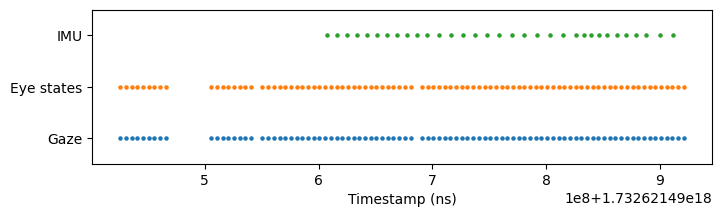

In [30]:
# Take the first 0.5 seconds of gaze data
gaze_begin = gaze.crop(0, 0.5, by="time")
# And the corresponding eye states and IMU data
eye_states_begin = eye_states.restrict(gaze_begin)
imu_begin = imu.restrict(gaze_begin)


# Define a function to plot the timestamps of the gaze, eye states, and IMU data
def plot_timestamps(gaze, eye_states, imu):
    _, ax = plt.subplots(figsize=(8, 2))
    ax.scatter(gaze.ts, np.ones_like(gaze.ts), s=5)
    ax.scatter(eye_states.ts, np.ones_like(eye_states.ts) * 2, s=5)
    ax.scatter(imu.ts, np.ones_like(imu.ts) * 3, s=5)
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(["Gaze", "Eye states", "IMU"])
    ax.set_ylim(0.5, 3.5)
    ax.set_xlabel("Timestamp (ns)")
    plt.show()


plot_timestamps(gaze_begin, eye_states_begin, imu_begin)

As apparent from the figure above, in addition to the apparently later onset of IMU data, during the first 0.5 seconds of the recording the data suffers from dropouts and irregular sampling. While this is a common issue for the first few samples due to device boot-up, it could also happen at any time during the recording. For example, even in the middle of a recording (5 - 5.5 seconds), some irregular sampling might still be observed:

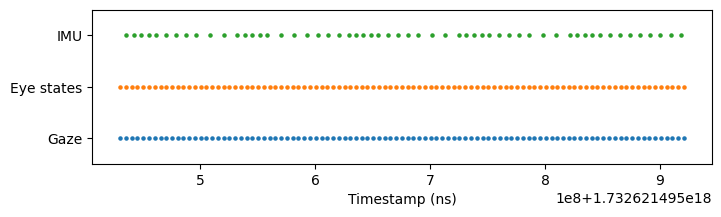

In [31]:
gaze_middle = gaze.crop(5, 5.5, by="time")
eye_states_middle = eye_states.restrict(gaze_middle)
imu_middle = imu.restrict(gaze_middle)

plot_timestamps(gaze_middle, eye_states_middle, imu_middle)

Some irregular sampling in the IMU data is observed in this segment of the recording as well. How frequent are these irregularities? Let's take a look at the distribution of the time differences between consecutive samples, and compare them to the expected time difference for a regular, nominal (as specified by Pupil Labs) sampling rate.

Nominal sampling frequency of gaze: 200 Hz. Actual: 199.36 Hz
Nominal sampling frequency of eye states: 200 Hz. Actual: 199.36 Hz
Nominal sampling frequency of IMU: 110 Hz. Actual: 113.88 Hz


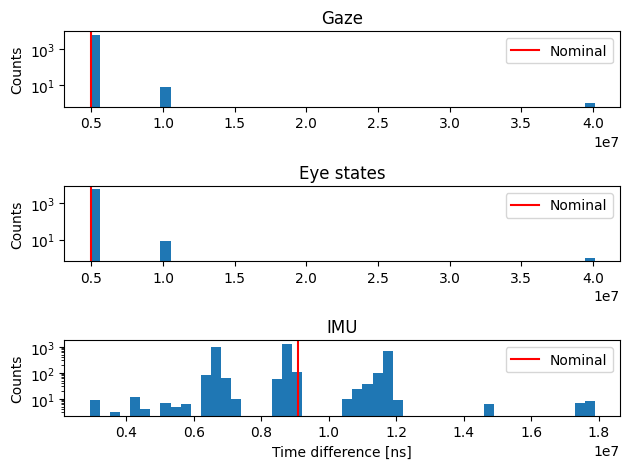

In [37]:
print(
    f"Nominal sampling frequency of gaze: {gaze.sampling_freq_nominal} Hz. "
    f"Actual: {gaze.sampling_freq_effective:.2f} Hz"
)
print(
    f"Nominal sampling frequency of eye states: {eye_states.sampling_freq_nominal} Hz. "
    f"Actual: {eye_states.sampling_freq_effective:.2f} Hz"
)
print(
    f"Nominal sampling frequency of IMU: {imu.sampling_freq_nominal} Hz. "
    f"Actual: {imu.sampling_freq_effective:.2f} Hz"
)

fig, axs = plt.subplots(3, 1, tight_layout=True)

axs[0].hist(gaze.ts_diff, bins=50)
axs[0].axvline(1e9 / gaze.sampling_freq_nominal, c="red", label="Nominal")
axs[0].set_title("Gaze")

axs[1].hist(eye_states.ts_diff, bins=50)
axs[1].axvline(1e9 / eye_states.sampling_freq_nominal, c="red", label="Nominal")
axs[1].set_title("Eye states")

axs[2].hist(imu.ts_diff, bins=50)
axs[2].axvline(1e9 / imu.sampling_freq_nominal, c="red", label="Nominal")
axs[2].set_title("IMU")
axs[2].set_xlabel("Time difference [ns]")

for i in range(3):
    axs[i].set_yscale("log")
    axs[i].set_ylabel("Counts")
    axs[i].legend()
plt.show()

For gaze and eye states data, the empirical distribution of time differences is close to the expected value (though with some integer multiples of the nominal sampling rate, which hints at possible eye video frame drops). For IMU data, the distribution is much wider.

## Interpolating data streams

Given the presence of irregular sampling, if you want to perform analyses that assume continuous data streams, interpolation is necessary. PyNeon uses the `scipy.interpolate.interp1d` [(API reference)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) function to interpolate data streams. For instances of `NeonStream`, we can call `interpolate()` which returns a copy of the object with the data interpolated with the default parameters.

In [33]:
# Resample to the nominal sampling frequency
gaze_resampled = gaze.interpolate()

# Three ways you can check if the resampling was successful:
# 1. Compare the effective sampling frequency to the nominal sampling frequency
print(
    f"Nominal sampling frequency of gaze: {gaze_resampled.sampling_freq_nominal} Hz. "
    f"Actual (after interpolation): {gaze_resampled.sampling_freq_effective:.2f} Hz"
)
# 2. Check the number of unique time differences
print(f"Only one unique time difference: {np.unique(gaze_resampled.ts_diff)}")
# 3. Call the `is_uniformly_sampled` property (boolean)
print(
    f"The new gaze stream is uniformly sampled: {gaze_resampled.is_uniformly_sampled}"
)

Nominal sampling frequency of gaze: 200 Hz. Actual (after interpolation): 200.03 Hz
Only one unique time difference: [5000000]
The new gaze stream is uniformly sampled: True


In the above example, we resampled the gaze data with default parameters, which means that the resampled data will have the same start and timestamps as the original data, and the sampling rate is set to the nominal sampling frequency (200 Hz, as specified by Pupil Labs). Notice that resampling would not change the data type of the columns. For example, the `bool`-type `worn` column and the integer-type `fixation_id` column are preserved.
nominal sampling rate (you can also customize by passing the `new_ts` argument).

Alternatively, one can also resample the gaze data to any desired timestamps by specifying the `new_ts` parameter. This is especially helpful when synchronizing different data streams. For example, we can resample the gaze data (~200Hz) to the timestamps of the IMU data (~110Hz).

In [34]:
print(f"Original gaze data length: {gaze.data.shape[0]}")
print(f"Original IMU data length: {imu.data.shape[0]}")
gaze_resampled_to_imu = gaze.interpolate(new_ts=imu.ts)
print(
    f"Gaze data length after resampling to IMU: {gaze_resampled_to_imu.data.shape[0]}"
)

Original gaze data length: 6091
Original IMU data length: 3459
Gaze data length after resampling to IMU: 3459


## Concatenating different streams

Based on the resampling method, it is then possible to concatenate different streams into a single DataFrame by resampling them to common timestamps. The method `concat_streams()` provides such functionality. It takes a list of stream names and resamples them to common timestamps, defined by the latest start and earliest end timestamps of the streams. The news ampling frequency can either be directly specified or taken from the lowest/highest sampling frequency of the streams.

In the following example, we will concatenate the gaze, eye states, and IMU streams into a single DataFrame using the default parameters (e.g., using the lowest sampling frequency of the streams).

In [35]:
concat_stream = recording.concat_streams(["gaze", "eye_states", "imu"])
print(concat_stream.data.head())

Concatenating streams:
	Gaze
	3D eye states
	IMU
Using lowest sampling rate: 110 Hz (['imu'])
Using latest start timestamp: 1732621490607650343 (['imu'])
Using earliest last timestamp: 1732621520979070343 (['gaze' '3d_eye_states'])
                     gaze x [px]  gaze y [px]  worn  fixation id  blink id  \
1732621490607650343   705.518843   554.990998     1            1      <NA>   
1732621490616741252   704.882466   553.793144     1            1      <NA>   
1732621490625832161   707.703787   556.712159     1            1      <NA>   
1732621490634923070   711.389879   553.846843     1            1      <NA>   
1732621490644013979   709.281775   555.543777     1            1      <NA>   

                     azimuth [deg]  elevation [deg]  pupil diameter left [mm]  \
1732621490607650343      -7.085339         3.473196                  3.346414   
1732621490616741252      -7.126717         3.550038                  3.363306   
1732621490625832161      -6.944033         3.363048     

We show an exemplary sampling of eye, imu and concatenated data below. It can be seen that imu data has subsequent missing values which can in turn be interpolated

In [36]:
start_time = 5
end_time = 5.3
start_ts = time_to_ts(start_time, concat_stream)
end_ts = time_to_ts(end_time, concat_stream)

raw_gaze_data_slice = gaze.data[
    (gaze.data["timestamp [ns]"] >= start_ts) & (gaze.data["timestamp [ns]"] <= end_ts)
]
raw_eye_states_data_slice = eye_states.data[
    (eye_states.data["timestamp [ns]"] > start_ts)
    & (eye_states.data["timestamp [ns]"] <= end_ts)
]
raw_imu_data_slice = imu.data[
    (imu.data["timestamp [ns]"] >= start_ts) & (imu.data["timestamp [ns]"] <= end_ts)
]
concat_data_slice = concat_stream[
    (concat_stream["timestamp [ns]"] >= start_ts)
    & (concat_stream["timestamp [ns]"] <= end_ts)
]

# plot all data in the same scatter plot
plt.figure(figsize=(15, 4))
plt.scatter(
    raw_gaze_data_slice["timestamp [ns]"],
    np.zeros_like(raw_gaze_data_slice["timestamp [ns]"]) + 2,
    label="Raw gaze data",
    color="red",
)
plt.scatter(
    raw_eye_states_data_slice["timestamp [ns]"],
    np.zeros_like(raw_eye_states_data_slice["timestamp [ns]"]) + 1,
    label="Raw eye states data",
    color="orange",
)
plt.scatter(
    raw_imu_data_slice["timestamp [ns]"],
    np.zeros_like(raw_imu_data_slice["timestamp [ns]"]),
    label="Raw IMU data",
    color="blue",
)
plt.scatter(
    concat_data_slice["timestamp [ns]"],
    np.zeros_like(concat_data_slice["timestamp [ns]"]) - 1,
    label="Concatenated data",
    color="green",
)
# set x-ticks with higher frequency and add gridlines
plt.xticks(concat_data_slice["timestamp [ns]"], labels=None)
plt.yticks([])
plt.grid()
plt.legend()

NameError: name 'time_to_ts' is not defined

A linear interpolation allows us to estimate missing values. In the end, the concatenated dataframe combines all continuous data into one central location

In [ ]:
# plot imu data and interpolated data in same plot
plt.figure(figsize=(16, 3))
plt.scatter(
    raw_imu_data_slice["time [s]"],
    raw_imu_data_slice["acceleration z [g]"],
    label="Raw imu data",
    color="blue",
)
plt.plot(
    concat_data_slice["time [s]"],
    concat_data_slice["acceleration z [g]"],
    label="Interpolated imu data",
    color="green",
)
plt.legend()